# Bayesian multi-objective optimization with BoTorch
In this notebook we use BoTorch to implement a Bayesian multi-objective optimization algorithm to explore the Pareto front of a system with two conflicting outputs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyreto
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import torch
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import qUpperConfidenceBound, qExpectedImprovement, GenericMCObjective, LinearMCObjective
from botorch.optim import optimize_acqf

### Plotting helpers

In [2]:
def plot_problem(data=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    
    # Isocontours
    levels = 41
    X = pyreto.util.cube_grid(2, levels)
    Y = problem.f(X, noise=0)
    X1 = X.reshape(levels, levels, 2)[..., 0]
    X2 = X.reshape(levels, levels, 2)[..., 1]
    Y1 = Y.reshape(levels, levels, 2)[..., 0]
    Y2 = Y.reshape(levels, levels, 2)[..., 1]
    ax1.contour(X1, X2, Y1)
    ax1.contour(X1, X2, Y2, linestyles='--')
    
    # Data
    if data is not None:
        ax1.scatter(*data[problem.inputs].values.T)
        ax2.scatter(*data[problem.outputs].values.T)
    else:
        ax2.scatter(Y1, Y2, s=10, alpha=0.2)
        
    # Pareto front
    pareto_X, pareto_Y = problem.pareto_front(levels=50)
    ax1.plot(*pareto_X.T, color='C1')
    ax2.plot(*pareto_Y.T, color='C1')
    ax1.scatter(*problem.optimizer.T, c='C1', marker='o')
    ax2.scatter(*problem.f(problem.optimizer, noise=0).T, c='C1', marker='o')
    
    ax1.set(title="Input space", xlabel='$x_1$', ylabel='$x_2$', xlim=(0, 1), ylim=(0, 1))
    ax2.set(title="Output space", xlabel='$y_1$', ylabel='$y_2$', xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))

def plot_model(model, data):
    levels = 21
    X = torch.tensor(pyreto.util.cube_grid(2, levels), dtype=torch.float)
    dist = model(X)
    X1 = X.reshape(levels, levels, 2)[..., 0]
    X2 = X.reshape(levels, levels, 2)[..., 1]
    mean = dist.mean.reshape(2, levels, levels).detach().numpy()
    std = dist.variance.reshape(2, levels, levels).detach().numpy() ** 0.5

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.1, wspace=0.05)

    ax1.contour(X1, X2, mean[0], levels=15)
    ax1.contour(X1, X2, std[0], linewidths=0.5, linestyles='--', levels=15)
    ax1.scatter(*data[problem.inputs].values.T)

    ax2.contour(X1, X2, mean[1], levels=15)
    ax2.contour(X1, X2, std[1], linewidths=0.5, linestyles='--', levels=15)
    ax2.scatter(*data[problem.inputs].values.T)

    ax1.set(title="Output $y_1$", xlabel="$x_1$", ylabel='$x_2$', xlim=(0, 1), ylim=(0, 1))
    ax2.set(title="Output $y_2$", xlabel="$x_1$")
    fig.suptitle('GP posterior mean (solid) and standard deviation (dashed)');
    
def plot_acquisition(acquisition, data=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    # acquisition contours
    levels = 21
    test_X = torch.tensor(pyreto.util.cube_grid(problem.n_inputs, levels), dtype=torch.float)
    test_A = acquisition(test_X.reshape(-1, 1, problem.n_inputs))  # add q-dimension
    ax.contour(
        test_X[:, 0].reshape(21, 21).detach().numpy(),
        test_X[:, 1].reshape(21, 21).detach().numpy(),
        test_A.reshape(21, 21).detach().numpy(),
        levels=15,
    )    
    
    # Pareto front
    pareto_X, pareto_Y = problem.pareto_front(levels=50)
    ax.plot(*pareto_X.T, color='C1')
    ax.scatter(*problem.optimizer.T, color='C1')
    
    # data
    if data is not None:
        ax.scatter(*data[problem.inputs].values.T)
    
    ax.set(xlabel="$x_1$", ylabel="$x_2$", xlim=(0, 1), ylim=(0, 1))

### The Problem

We consider a system with two inputs ($x_1, x_2$) and two conflicting outputs ($y_1, y_2$) of the form $y_m(x) \sim |x - x_m^*|_2$ which are to be minimized in the domain $x \in [0, 1]^2$.   
The left plot shows the response for the two outputs as solid and dashed lines. Orange dots indicate the position of the individual optima $x_m^*$, and the connecting orange line indicates the Pareto set.  
The right plot shows the corresponding output space with blue dots indicating the feasible solutions, and the Pareto front shown in orange.

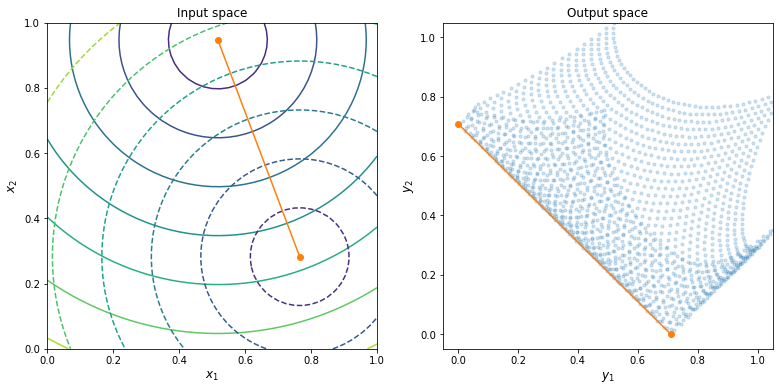

In [3]:
problem = pyreto.problem.ConvexProblem(n_inputs=2, n_outputs=2, noise=0.01, seed=23)
plot_problem()

### Initial data
As initial data we randomly sample 5 points. Evaluations of the system are noisy, hence the experimental output values may be slightly better than the true Pareto front. 

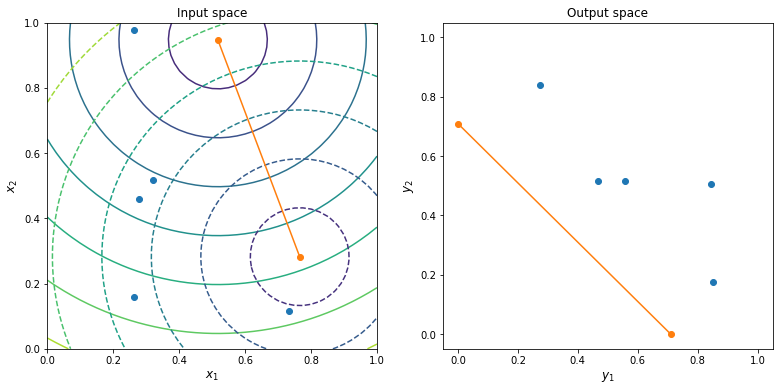

In [4]:
np.random.seed(1337)
X = np.random.rand(5, problem.n_inputs)
Y = problem.f(X)

data = pd.DataFrame(
    columns=problem.inputs + problem.outputs,
    data=np.column_stack([X, Y])
)
plot_problem(data)

### Surrogate model
We fit a GP process with a Matern kernel seperately to each standard-normalized output.  
The plots below shows the posterior mean (solid lines) and standard deviation (dashed lines) for $y_1$ (left) and $y_2$ (right). Even with few samples the model predictivity is good, owing to the low dimensional input space and the outputs' smooth functional dependencies. 

In [5]:
def fit_model(data):
    X = data[problem.inputs].values
    Y = data[problem.outputs].values
    scaler = StandardScaler().fit(Y)
    
    model = SingleTaskGP(
        torch.tensor(X, dtype=torch.float),
        torch.tensor(scaler.transform(Y), dtype=torch.float)
    )
    fit_gpytorch_model(ExactMarginalLogLikelihood(model.likelihood, model))
    return model

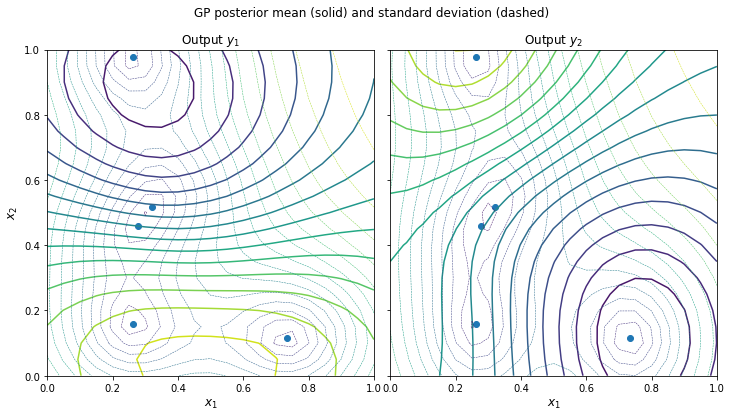

In [6]:
model = fit_model(data)
plot_model(model, data)

In [7]:
model

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

In [8]:
print(f'noise var:  {model.likelihood.noise.detach().numpy().T}')
print(f'mean        {model.mean_module.constant.detach().numpy().T}')
print(f'kernel var: {model.covar_module.outputscale.detach().numpy()}')
print(f'kernel ls:  {model.covar_module.base_kernel.lengthscale.detach().numpy()}')

noise var:  [[0.00923564 0.00550954]]
mean        [[0.00941851 0.1103615 ]]
kernel var: [1.7198578 1.9162292]
kernel ls:  [[[0.4782827  0.41704914]]

 [[0.39980033 0.49347764]]]


### Acquistion function
For Bayesian optimization we need to formulate an acquisition function that quantifies the tradeoffs between exploration and exploitation on the one hand, and between the individual outputs on the other hand. In the following we scalarize outputs in order to use a standard single-objective acquisition function for the exploration-exploitation tradeoff. As scalarization we could use a linear combination of the outputs, which would preferably search close the two individual optima since the ooutputs increase with the square of the distance. Instead, we use the weighted p-norm of the distance to an utopian reference point $u$ which results in a better coverage of the Pareto front:
\begin{align}
s(y) = \left( \sum_m w_m \left( y_m - u_m \right)^p \right)^{1/p}
\end{align}
In each Bayesian optimization step we choose a random weight vector $w$, which we sample uniformly from the unit-simplex in order to achieve a uniform sampling of the Pareto front.
The choice of $p$ is somewhat arbitrary. In the following we use $p=2$. For non-convex Pareto front it is necessary to choose a high $p$ in order to be able to reach all points on the front.
As the utopian point we can use the (infeasible) combination of the individual minima or any point that is better.

**Notes**
* Since the GP predicts the standard-normalized outputs, we need to apply the same transformation to the utopian reference point, otherwise we would be optimizing for mediocre outputs :).
* BoTorch assumes maximization, hence we maximize the negative weighted norm.

In [9]:
def make_acquisition(model, data, weights=None):
    if weights is None:
        # random weight vector on the unit simplex
        weights = np.random.exponential(size=(problem.n_outputs))
        weights /= weights.sum()
    weights = torch.tensor(weights, dtype=torch.float)
    
    # objective = LinearMCObjective(- weights)
    scaler = StandardScaler().fit(data[problem.outputs])  
    utopian = torch.tensor(scaler.transform(problem.utopian[np.newaxis]), dtype=torch.float)
    objective = GenericMCObjective(lambda samples: - torch.norm((samples - utopian) * weights, p=2, dim=-1))
    return qUpperConfidenceBound(model, beta=1, objective=objective)

Below we see the acquisition contour for a weighted 2-norm with three different weights. Since the initial model is already rather predictive, we can see that with the weights the optimum of the acquisition function moves along the Pareto set.

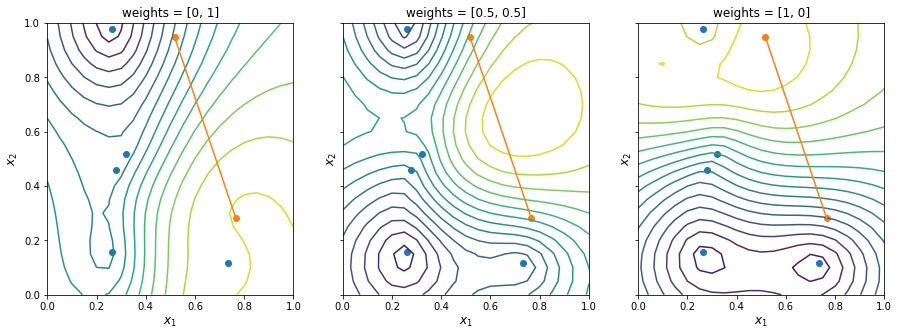

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
for i, weights in enumerate([[0, 1], [0.5, 0.5], [1, 0]]):
    acq = make_acquisition(model, data, weights)
    plot_acquisition(acq, data, axs[i])
    axs[i].set_title(f"weights = {weights}")

### Bayesian optimization loop
Now we can set up the BO loop by combining the steps of model fitting, formulating an acquisition function with random weights, selecting a candidate point by optimizing that acquistion, and evaluating the outputs at the candidate point.

In [11]:
def select_candidate(acqusition):
    x, _ = optimize_acqf(
        acquisition,
        bounds=torch.tensor(problem.bounds, dtype=torch.float),
        q=1, 
        num_restarts=10, 
        raw_samples=256
    )
    return x.detach().numpy()

In [12]:
for i in tqdm(range(20)):
    model = fit_model(data)
    acquisition = make_acquisition(model, data)
    x = select_candidate(acquisition)
    y = problem.f(x)
    idx = len(data)
    data.loc[idx, problem.inputs] = x
    data.loc[idx, problem.outputs] = y

100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


Looking at the results after 20 iterations we see that the algorithm nicely spent almost all function evaluations on exploring the true Pareto front, while ignoring uninteresting rest of the input space.

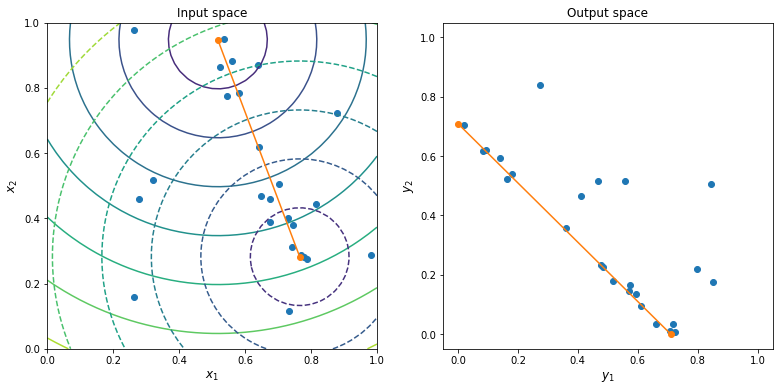

In [13]:
plot_problem(data)

### Performance metrics

In [14]:
pareto_X, pareto_Y = problem.pareto_front(levels=50)
for i in range(len(data)):
    Yi = data.loc[: i + 1, problem.outputs].values
    Yi = pyreto.util.pareto_subset(Yi)
    #hv = pyreto.metric.hypervolume(Yi, ref_point=problem.nadir)
    #print(hv, type(hv))
    data.loc[i, "HV"] = pyreto.metric.hypervolume(Yi, ref_point=problem.nadir)
    data.loc[i, "GD"] = pyreto.metric.generational_distance(Yi, pareto_Y)
    data.loc[i, "IGD"] = pyreto.metric.inverted_generational_distance(Yi, pareto_Y)

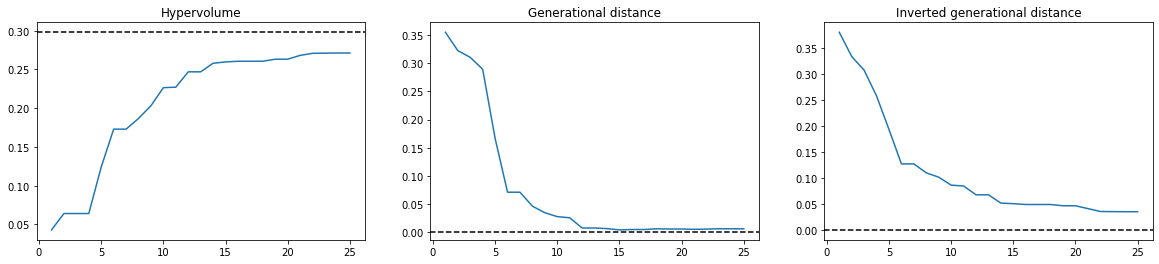

In [15]:
steps = np.arange(len(data)) + 1
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 4))

ax1.plot(steps, data["HV"])
ax1.axhline(pyreto.metric.hypervolume(pareto_Y, ref_point=problem.nadir), color='k', ls='--')
ax1.set(title="Hypervolume");

ax2.plot(steps, data["GD"])
ax2.axhline(0, color='k', ls='--')
ax2.set(title="Generational distance");

ax3.plot(steps, data["IGD"])
ax3.axhline(0, color='k', ls='--')
ax3.set(title="Inverted generational distance");